In [54]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
panel_rent_per_sf_per_neighborhood = pd.read_csv('../data/panel_rent_per_sf_per_neighborhood.csv', index_col=0)
panel = gpd.read_feather('../data/panel_data_estimated_costs.geofeather')
panel_df = pd.merge(panel, panel_rent_per_sf_per_neighborhood)

In [6]:
panel_df.sample(10)[['home_size1', 'year', 'rent/sf', 'assessor_neighborhood']]

,home_size1,year,rent/sf,assessor_neighborhood
667304,1200.0,2013.0,587.519481,Yerba Buena
586877,1388.0,2013.0,290.000000,Bayview
252729,1378.7,2016.0,1191.000000,Russian Hill
379866,1717.5,2014.0,752.000000,Forest Hill Extension
1013171,1250.0,2007.0,559.000000,Outer Mission
518437,1200.0,2014.0,791.000000,Merced Heights
1181346,1387.0,2010.0,389.000000,South of Market
706342,1458.0,2008.0,629.000000,Outer Richmond
522024,1200.0,2014.0,532.000000,Oceanview
777635,1336.0,2016.0,638.000000,Portola


### Unit count data

In [75]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [76]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [77]:
date_cols = [c for c in dbi.columns if 'date' in c]
dbi[date_cols] = dbi[date_cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))
cost_cols = [c for c in dbi.columns if 'cost' in c]
dbi[cost_cols] = dbi[cost_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
unit_cols = [c for c in dbi.columns if 'unit' in c]
dbi[unit_cols] = dbi[unit_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [78]:
panel_df.columns

Index(['MapBlkLot_Master', 'year', 'Developed', 'Historic',
       'Residential_Dummy', 'Zillow_Price_Real', 'Const_FedReserve_Real',
       'Envelope_1000', 'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'geometry', 'mapblklot', 'property_class_code_definition',
       'lot_code', 'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'closed_roll_year', 'status_code', 'number_of_bedrooms',
       'assessor_neighborhood', 'number_of_stories',
       'assessor_neighborhood_district', 'exemption_code_definition', 'block',
       'current_sales_date', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'hom

In [79]:
dbi = dbi.sort_values('permit_creation_date', ascending=False)
dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
permits = pd.merge(dbi[['geometry', 'permit_number', 'permit_creation_date']],
                   homes,
                   left_on='permit_number', right_on='BPA', how='inner')
permits = permits[['geometry', 'permit_number', 'Permit Issued Date', 'Net_Units_Completed', 'Date_Completed', 'BlockLot']]


In [80]:
panel_df_pois = gpd.sjoin(panel_df, permits.to_crs(panel_df.crs), how='left', predicate='contains')

In [81]:
panel_df_pois.Developed = panel_df_pois.index_right.notna()

In [83]:
panel_df_pois.Net_Units_Completed = panel_df_pois.Net_Units_Completed.fillna(0)

In [88]:
panel_df_pois = panel_df_pois.drop(columns='index_right')

### Fires

In [7]:
fires = gpd.read_feather('../data/clean_accidental_fires.geofeather')

In [13]:
fires.columns

Index(['geometry', 'number_of_floors_with_significant_damage',
       'number_of_floors_with_heavy_damage',
       'number_of_floors_with_extreme_damage', 'address', 'property_use',
       'estimated_contents_loss', 'estimated_property_loss', 'alarm_dttm',
       'incident_date', 'number_of_floors_with_minimum_damage',
       'number_of_alarms', 'civilian_injuries', 'year'],
      dtype='object')

In [84]:
panel_df_pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
panel_fires = gpd.sjoin(panel_df_pois,
                        fires[['geometry',
                               'estimated_property_loss',
                               'incident_date']].rename(columns= 
                                                        {'estimated_property_loss' : 'fire_damage', 
                                                         'incident_date': 'fire_date'}), 
                        how='left',
                        predicate='contains')

In [90]:
panel_fires.index_right.notna().sum()

4569

In [91]:
panel_fires = panel_fires.drop(columns=['index_right'])

In [92]:
panel_fires.fire_damage.fillna(0, inplace=True)

In [93]:
(panel_fires.year - panel_fires.fire_date.dt.year).sample(10)

1022992   NaN
578894    NaN
1269491   NaN
464355    NaN
140759    NaN
853232    NaN
694302    NaN
156266    NaN
803950    NaN
1200137   NaN
dtype: float64

In [94]:
panel_fires['years_since_fire'] = panel_fires.year - panel_fires.fire_date.dt.year

In [95]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()]

72         -1.0
116        -7.0
190       -10.0
195       -10.0
1007        5.0
           ... 
1325535     4.0
1326518    -4.0
1327011   -11.0
1327053     4.0
1328110    -8.0
Name: years_since_fire, Length: 4569, dtype: float64

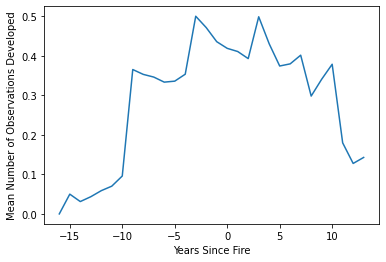

In [96]:
# Compute the mean for each unique value of 'years_since_fire'
plot_data = panel_fires.groupby('years_since_fire')['Developed'].mean().reset_index()

# Plot using seaborn
sns.lineplot(x='years_since_fire', y='Developed', data=plot_data)
plt.ylabel('Mean Number of Observations Developed')
plt.xlabel('Years Since Fire')
plt.show()

In [97]:
 panel_fires.groupby('years_since_fire')['Developed'].mean()

years_since_fire
-16.0    0.000000
-15.0    0.050000
-14.0    0.031250
-13.0    0.043478
-12.0    0.058824
-11.0    0.070175
-10.0    0.095890
-9.0     0.365217
-8.0     0.352941
-7.0     0.346154
-6.0     0.333333
-5.0     0.335821
-4.0     0.353383
-3.0     0.500000
-2.0     0.471264
-1.0     0.435644
 0.0     0.418803
 1.0     0.410788
 2.0     0.392857
 3.0     0.498681
 4.0     0.430267
 5.0     0.374126
 6.0     0.379562
 7.0     0.401515
 8.0     0.298077
 9.0     0.340659
 10.0    0.378571
 11.0    0.179775
 12.0    0.127660
 13.0    0.142857
Name: Developed, dtype: float64

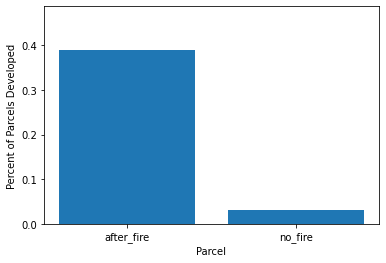

In [104]:
panel_fires['fire_category'] = np.where(panel_fires['years_since_fire'].fillna(-1) < 0, 'no_fire', 'after_fire')

# Compute the mean for each category
plot_data = panel_fires.groupby('fire_category')['Developed'].mean().reset_index()

# Plot using matplotlib
plt.bar(plot_data['fire_category'], plot_data['Developed'])

# Set y-axis limit to 110% of the maximum value
plt.ylim(0, plot_data['Developed'].max() * 1.25)

plt.ylabel('Percent of Parcels Developed')
plt.xlabel('Parcel')
plt.show()

In [103]:
panel_fires.groupby('years_since_fire')['Net_Units_Completed'].mean()

years_since_fire
-16.0    0.000000
-15.0   -0.050000
-14.0   -0.031250
-13.0    1.282609
-12.0    1.137255
-11.0    2.333333
-10.0    5.643836
-9.0     1.678261
-8.0     1.621849
-7.0     2.307692
-6.0     2.050725
-5.0    -0.037313
-4.0     0.000000
-3.0    -1.307229
-2.0    -1.241379
-1.0     0.222772
 0.0    -0.196581
 1.0    -0.178423
 2.0    -0.467857
 3.0    -0.891821
 4.0    -1.486647
 5.0    -0.968531
 6.0    -1.021898
 7.0    -1.075758
 8.0    -1.932692
 9.0    -2.208791
 10.0   -2.207143
 11.0   -1.067416
 12.0   -0.106383
 13.0   -0.142857
Name: Net_Units_Completed, dtype: float64

### Revenue & Cost

In [110]:
panel_fires['revenue'] = panel_fires['rent/sf'] * panel_fires['Envelope_1000'] * 1000

In [112]:
panel_fires['costs'] = (panel_fires['estimated_cost'] - panel_fires['fire_damage']
                        + panel_fires['imputed_land_value'] + panel_fires['assessed_improvement_value'])

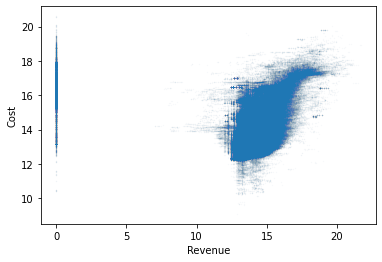

In [123]:
plt.scatter(np.log1p(panel_fires['revenue']), np.log1p(panel_fires['costs']), alpha=.05, s=.1)
plt.xlabel('Revenue')
plt.ylabel('Cost')
plt.show()

(0.0, 100.0)

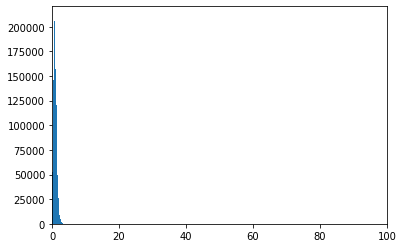

In [130]:
plt.hist(np.log1p(panel_fires['revenue'] / panel_fires['costs']), bins=40)
plt.xlim(0, 100)

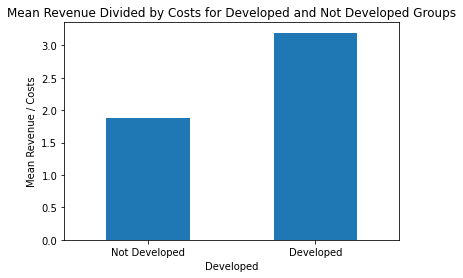

In [134]:
result = panel_fires.groupby('Developed').apply(lambda x: (x['revenue'] / x['costs']).mean())

# Create the bar plot
result.plot(kind='bar', ylabel='Mean Revenue / Costs', title='Mean Revenue Divided by Costs for Developed and Not Developed Groups')
plt.xticks(ticks=[0, 1], labels=['Not Developed', 'Developed'], rotation=0)
plt.show()

In [132]:
panel_fires.to_csv('./panel_fires.csv', index=False)